# Notebook to explore netCDF files and change resolution, plus Python plotting
These files are downloaded from [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=download), using `cdsapi`. Get the data running the Python script `inout.py`:
```
python onehealth_db/inout.py
```

The downloaded files are stored in `data/in`. The `area` option uses values `90`, `90`, `-90`, `-90` for `North`, `East`, `South`, `West`, respectively.

Question: What is the coordinate reference system for the era5 dataset? NUTS3 either on EPSG 3035, 4326, 3857.

-> According to [ERA5-Land's documentation](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation):
> The data is referenced in the horizontal with respect to the WGS84 ellipse (which defines the major/minor axes) and in the vertical it is referenced to the EGM96 geoid over land but over ocean it is referenced to mean sea level, with the approximation that this is assumed to be coincident with the geoid. 

Then according to [this page](https://spatialreference.org/ref/epsg/9707/), it seems like the coordinate reference system for ERA5-Land is EPSG:9707

> ERA5-Land produces a total of 50 variables describing the
water and energy cycles over land, globally, hourly, and at a
spatial resolution of 9 km, matching the ECMWF triangular–
cubic–octahedral (TCo1279) operational grid (Malardel
et al., 2016).

In [1]:
from pathlib import Path
import xarray as xr
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pandas as pd

The following cells aim to explore the data structure

In [2]:
folder_path = Path("../data/in")

### ERA5-Land from CDS

In [ ]:
f_area_before_celsius = folder_path / "era5_data_2024_01_02_03_2t_tp_monthly.nc"
f_area_after_celsius = folder_path / "era5_data_2024_01_02_03_2t_tp_monthly_celsius.nc"

In [ ]:
# load netCDF files
ds_area_before_celsius = xr.open_dataset(f_area_before_celsius)
ds_area_after_celsius = xr.open_dataset(f_area_after_celsius)

#### Dask Array

In [ ]:
dask_ds = xr.open_dataset(f_area_after_celsius, chunks={})
dask_ds = dask_ds.chunk({"valid_time": 1, "latitude": 1801, "longitude": 3600})
t2m_data = dask_ds["t2m"].dropna(dim="latitude", how="all").load() # load data into memory
t2m_data

In [ ]:
stacked = t2m_data.stack(points=("valid_time", "latitude", "longitude"))
stacked

In [ ]:
stacked = stacked.dropna("points")
stacked

In [ ]:
stacked["valid_time"].values.astype("datetime64[ns]")

In [ ]:
stacked["latitude"].values

In [ ]:
stacked["longitude"].values

In [ ]:
stacked.values

In [ ]:
ds_area_before_celsius

In [ ]:
ds_area_before_celsius.sel(latitude=20.0, longitude=10.0, method="nearest").to_dataframe().head(5)

In [ ]:
ds_area_before_celsius["tp"].attrs

In [ ]:
ds_area_after_celsius

In [ ]:
ds_area_after_celsius.latitude.values[5]

In [ ]:
ds_area_after_celsius["tp"].attrs

In [ ]:
ds_area_after_celsius.sel(latitude=20.0, longitude=10.0, method="nearest").to_dataframe().head(5)

In [ ]:
ds_area_after_celsius.latitude.values[5]

In [ ]:
lat = 20.0
lon = 10.0
ds_area_after_celsius["t2m"].sel(latitude=lat, longitude=lon, method="nearest").plot(color="blue", marker="o")
plt.title("2m temperature in 2024 at lat-{}, lon-{}".format(lat, lon))
plt.show()


In [ ]:
# plot the data for the first month
ds_area_after_celsius.t2m[0].plot(size = 7)

In [ ]:
ds_area_after_celsius.tp[0].plot(size = 7)

In [ ]:
# convert to dataframe
df = ds_area_after_celsius.to_dataframe().reset_index()
df

### Population data from ISIMIP

In [3]:
f_popu_data = folder_path / "population_histsoc_30arcmin_annual_1901_2021.nc"
ds_popu_data = xr.open_dataset(f_popu_data, chunks={})

In [4]:
ds_popu_data

<xarray.Dataset> Size: 376MB
Dimensions:           (lat: 360, lon: 720, time: 121)
Coordinates:
  * lat               (lat) float64 3kB 89.75 89.25 88.75 ... -89.25 -89.75
  * lon               (lon) float64 6kB -179.8 -179.2 -178.8 ... 179.2 179.8
  * time              (time) datetime64[ns] 968B 1901-01-01T12:00:00 ... 2021...
Data variables:
    rural-population  (time, lat, lon) float32 125MB dask.array<chunksize=(121, 360, 720), meta=np.ndarray>
    total-population  (time, lat, lon) float32 125MB dask.array<chunksize=(121, 360, 720), meta=np.ndarray>
    urban-population  (time, lat, lon) float32 125MB dask.array<chunksize=(121, 360, 720), meta=np.ndarray>
Attributes:
    summary:     HYDE v3.3 population data linearly interpolated in time for ...
    references:  Klein Goldewijk et al. (2022), in preparation
    title:       ISIMIP3a population data
    contact:     "ISIMIP cross-sectoral science team" <info@isimip.org>

In [5]:
if ds_popu_data.time.values[0] > ds_popu_data.time.values[-1]:
    # sort the time dimension in ascending order
    ds_popu_data = ds_popu_data.sortby("time")
start_of_year = pd.Timestamp(
    year=pd.to_datetime(ds_popu_data.time.values[0]).year, month=1, day=1, hour=12, minute=0  # 0 hours for era5 data
)
end_of_year = pd.Timestamp(
    year=pd.to_datetime(ds_popu_data.time.values[-1]).year, month=12, day=1, hour=12, minute=0
)
monthly_time = pd.date_range(start=start_of_year, end=end_of_year, freq="MS")
monthly_time

DatetimeIndex(['1901-01-01 12:00:00', '1901-02-01 12:00:00',
               '1901-03-01 12:00:00', '1901-04-01 12:00:00',
               '1901-05-01 12:00:00', '1901-06-01 12:00:00',
               '1901-07-01 12:00:00', '1901-08-01 12:00:00',
               '1901-09-01 12:00:00', '1901-10-01 12:00:00',
               ...
               '2021-03-01 12:00:00', '2021-04-01 12:00:00',
               '2021-05-01 12:00:00', '2021-06-01 12:00:00',
               '2021-07-01 12:00:00', '2021-08-01 12:00:00',
               '2021-09-01 12:00:00', '2021-10-01 12:00:00',
               '2021-11-01 12:00:00', '2021-12-01 12:00:00'],
              dtype='datetime64[ns]', length=1452, freq='MS')

In [6]:
ds_popu_data = ds_popu_data.reindex(time=monthly_time, method="ffill")
ds_popu_data

<xarray.Dataset> Size: 5GB
Dimensions:           (lat: 360, lon: 720, time: 1452)
Coordinates:
  * lat               (lat) float64 3kB 89.75 89.25 88.75 ... -89.25 -89.75
  * lon               (lon) float64 6kB -179.8 -179.2 -178.8 ... 179.2 179.8
  * time              (time) datetime64[ns] 12kB 1901-01-01T12:00:00 ... 2021...
Data variables:
    rural-population  (time, lat, lon) float32 2GB dask.array<chunksize=(121, 360, 720), meta=np.ndarray>
    total-population  (time, lat, lon) float32 2GB dask.array<chunksize=(121, 360, 720), meta=np.ndarray>
    urban-population  (time, lat, lon) float32 2GB dask.array<chunksize=(121, 360, 720), meta=np.ndarray>
Attributes:
    summary:     HYDE v3.3 population data linearly interpolated in time for ...
    references:  Klein Goldewijk et al. (2022), in preparation
    title:       ISIMIP3a population data
    contact:     "ISIMIP cross-sectoral science team" <info@isimip.org>

In [7]:
ds_popu_data["total-population"].sel(
    lat=8.67, lon=49.39, method="nearest").to_dataframe().head(14)

,lat,lon,total-population
time,,,
1901-01-01 12:00:00,8.75,49.25,3132.187500
1901-02-01 12:00:00,8.75,49.25,3132.187500
1901-03-01 12:00:00,8.75,49.25,3132.187500
1901-04-01 12:00:00,8.75,49.25,3132.187500
1901-05-01 12:00:00,8.75,49.25,3132.187500
1901-06-01 12:00:00,8.75,49.25,3132.187500
1901-07-01 12:00:00,8.75,49.25,3132.187500
1901-08-01 12:00:00,8.75,49.25,3132.187500
1901-09-01 12:00:00,8.75,49.25,3132.187500


In [8]:
ds_popu_data["total-population"].attrs

{'units': '1', 'standard_name': 'total population'}

In [9]:
# resolution of population data
res = ds_popu_data.lat[1] - ds_popu_data.lat[0]
res

<xarray.DataArray 'lat' ()> Size: 8B
array(-0.5)

In [10]:
test_popu_data = ds_popu_data.sel(lat=8.67, lon=49.39, method="nearest").to_dataframe()
test_popu_data.head(5)

,lat,lon,rural-population,total-population,urban-population
time,,,,,
1901-01-01 12:00:00,8.75,49.25,3132.1875,3132.1875,0.0
1901-02-01 12:00:00,8.75,49.25,3132.1875,3132.1875,0.0
1901-03-01 12:00:00,8.75,49.25,3132.1875,3132.1875,0.0
1901-04-01 12:00:00,8.75,49.25,3132.1875,3132.1875,0.0
1901-05-01 12:00:00,8.75,49.25,3132.1875,3132.1875,0.0


<Axes: xlabel='time'>

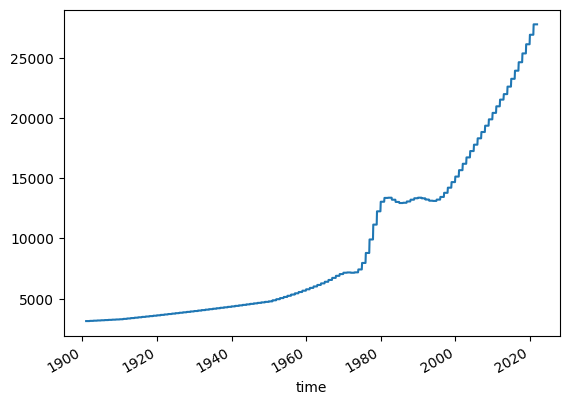

In [11]:
test_popu_data["total-population"].plot()

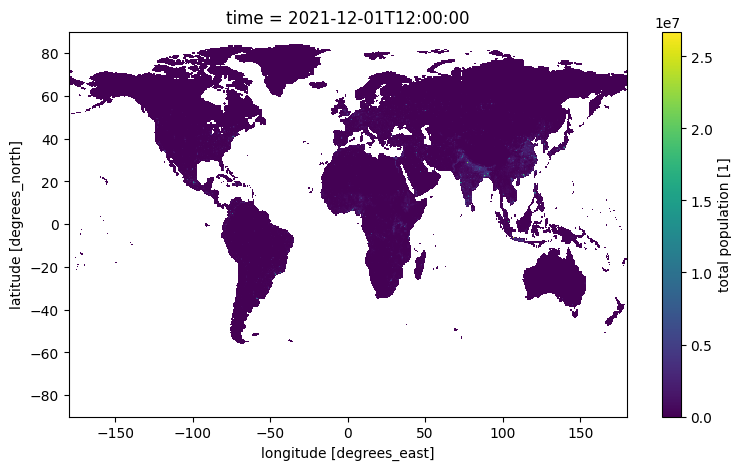

In [12]:
ds_popu_data["total-population"][-1].plot(figsize=(9, 5))

In [13]:
# change dimension name to make it consistent with the era5-land data
ds_popu_data = ds_popu_data.rename({"lat": "latitude", "lon": "longitude"})

In [14]:
# save the population data to a netCDF file
ds_popu_data.to_netcdf(folder_path / "population_histsoc_30arcmin_annual_1901_2021_renamed_monthly.nc", mode="w")

In [ ]:
# save the population data to a csv file
popu_data = ds_popu_data[["time", "latitude", "longitude", "total-population"]].to_dataframe().reset_index()
popu_data

In [ ]:
popu_data_clean = popu_data.dropna()
popu_data_clean

In [ ]:
# save population data to a csv file
popu_data.to_csv("../data/out/population_histsoc_30arcmin_annual_1901_2021_renamed_filtered_with_NAN.csv", index=False)
popu_data_clean.to_csv("../data/out/population_histsoc_30arcmin_annual_1901_2021_renamed_filtered.csv", index=False)

#### Files from provided materials

In [ ]:
f_popu_dens_2024 = folder_path / "pop_dens_2024_global_0.5.nc"
ds_popu_dens_2024 = xr.open_dataset(f_popu_dens_2024, decode_times=False) # add decode_times=False to avoid error
f_dens_example = folder_path / "dens_example.nc"
ds_dens_example = xr.open_dataset(f_dens_example)

In [ ]:
ds_popu_dens_2024

In [ ]:
ds_popu_dens_2024["dens"].attrs

In [ ]:
ds_popu_dens_2024.sel(lat=8.67, lon=49.39, method="nearest").to_dataframe().head(5)

In [ ]:
ds_dens_example

In [ ]:
ds_dens_example.to_dataframe().head(5)

## Downsampling of the data and setting the correct accuracy for the dataframe

In [ ]:
# aggregate the data to a 1/2 degree grid, about 50km x 50 km
# already here the numerical accuracy of the grid values is problematic, so we need to round
output_grid_resolution = 1/2
input_grid_resolution = np.round((ds_area_after_celsius.longitude[1]-ds_area_after_celsius.longitude[0]).item(),2)
print("Initial grid resolution is {}, downsampling to {} degree resolution".format(input_grid_resolution, output_grid_resolution))
weight = int(np.ceil(output_grid_resolution / input_grid_resolution))
print("Weight is {}".format(weight))

In [ ]:
ds_area_after_celsius

In [ ]:
ds_area_after_celsius = ds_area_after_celsius.rename({"valid_time": "time"})

In [ ]:
ds_area_after_celsius_resampled = ds_area_after_celsius.coarsen(longitude=weight, boundary="pad").mean().coarsen(latitude=weight, boundary="pad").mean()
ds_area_after_celsius_resampled

In [ ]:
# another version of using coarsen
ds_area_after_celsius_resampled_trim = ds_area_after_celsius.coarsen(longitude=weight, latitude=weight, boundary="trim").mean()
ds_area_after_celsius_resampled_trim

In [ ]:
downsampled_grid = float(ds_area_after_celsius_resampled.longitude[1] - ds_area_after_celsius_resampled.longitude[0])
print("Downsampled grid resolution is {}".format(downsampled_grid))

In [ ]:
downsampled_grid_trim = float(ds_area_after_celsius_resampled_trim.longitude[1] - ds_area_after_celsius_resampled_trim.longitude[0])
print("Downsampled grid resolution is {}".format(downsampled_grid_trim))

In [ ]:
# adjust lat and lon values to be consistent with the population data
ds_area_after_celsius_resampled_trim = ds_area_after_celsius_resampled_trim.assign_coords(
    {
        "latitude": (ds_area_after_celsius_resampled_trim.latitude - 0.05).round(2),
        "longitude": (ds_area_after_celsius_resampled_trim.longitude - 0.05).round(2),
    }
)
ds_area_after_celsius_resampled_trim

In [ ]:
# compare the adjusted lat lon values with the ones from the population data
era5_lat = ds_area_after_celsius_resampled_trim.latitude.values
era5_lon = ds_area_after_celsius_resampled_trim.longitude.values
popu_lat = ds_popu_data.latitude.values
popu_lon = ds_popu_data.longitude.values
test_lat = np.array_equal(era5_lat, popu_lat)
test_lon = np.array_equal(era5_lon, popu_lon)
test_lat, test_lon

In [ ]:
# plot the data for the first month
ds_area_after_celsius_resampled.t2m[0].plot(size = 5)

In [ ]:
ds_area_after_celsius_resampled_trim.t2m[0].plot(size = 5)

In [ ]:
# change m to mm for tp
ds_area_after_celsius_resampled_trim["tp"] = ds_area_after_celsius_resampled_trim["tp"] * 1000
ds_area_after_celsius_resampled_trim["tp"].attrs["units"] = "mm"
ds_area_after_celsius_resampled_trim["tp"].attrs["GRB_units"] = "mm"

In [ ]:
ds_area_after_celsius_resampled_trim.tp[0].plot(size = 5)

In [ ]:
# ds_area_after_celsius_resampled.to_netcdf("../data/out/era5_data_2024_01_02_03_2t_tp_monthly_celsius_mm_resampled_05degree_pad.nc")
ds_area_after_celsius_resampled_trim.to_netcdf("../data/out/era5_data_2024_01_02_03_2t_tp_monthly_celsius_mm_resampled_05degree_trim.nc")

#### Export to CSV files

In [ ]:
# convert to dataframe
df = ds_area_after_celsius_resampled_trim.to_dataframe().reset_index()
df

In [ ]:
out_data = df[["time", "latitude", "longitude", "t2m", "tp"]]

In [ ]:
# drop all nan values and filter by time
out_data_clean = out_data.dropna()
out_data_clean

In [ ]:
out_data.to_csv("../data/out/era5_data_2024_01_02_03_2t_tp_monthly_celsius_mm_with_NaN_resampled_05degree_trim.csv", index=False)
out_data_clean.to_csv("../data/out/era5_data_2024_01_02_03_2t_tp_monthly_celsius_mm_resampled_05degree_trim.csv", index=False)

## Export to geopandas for other plotting options and geospatial analysis

### Export to geopandas for ERA5-Land data

In [ ]:
# xarray data to geopandas
# Create geometry column using latitude and longitude
geometry = [Point(xy) for xy in zip(out_data['longitude'], out_data['latitude'])]

for epsg in [4326, 9707]:
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(out_data, geometry=geometry)

    # Set the coordinate reference system (CRS) if known (e.g., WGS84)
    gdf.set_crs(epsg=epsg, inplace=True)

    # Save to a GeoJSON file
    gdf.to_file(f"../data/out/era5_data_2024_01_02_2t_tp_monthly_celsius_with_NaN_February_resampled_05degree_{epsg}.geojson", driver="GeoJSON")

In [ ]:
# compare two files to see if the epsg makes a difference
gdf_9707 = gpd.read_file("../data/out/era5_data_2024_01_02_2t_tp_monthly_celsius_with_NaN_February_resampled_05degree_9707.geojson")
gdf_4326 = gpd.read_file("../data/out/era5_data_2024_01_02_2t_tp_monthly_celsius_with_NaN_February_resampled_05degree_4326.geojson")
diff = gdf_9707.compare(gdf_4326)
if diff.empty:
    print("The two files are identical.")
else:
    print("The two files are different.")
    print(diff)

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
gdf_4326.plot(ax=ax, column="t2m", legend=True, markersize=0.5)
fig.tight_layout()
fig.savefig("february_t2m_wNaN.pdf")

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
gdf_4326.plot(ax=ax, column="tp", legend=True, markersize=0.5)
fig.tight_layout()
fig.savefig("february_tp_wNaN.pdf")

### Export to geopandas for population data

In [ ]:
# xarray data to geopandas
# Create geometry column using latitude and longitude
geometry = [Point(xy) for xy in zip(popu_data['longitude'], popu_data['latitude'])]

for epsg in [4326, 9707]:
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(popu_data, geometry=geometry)

    # Set the coordinate reference system (CRS) if known (e.g., WGS84)
    gdf.set_crs(epsg=epsg, inplace=True)

    # Save to a GeoJSON file
    gdf.to_file(f"../data/out/isimip_population_with_NaN_2021_05degree_{epsg}.geojson", driver="GeoJSON")

In [ ]:
# compare two files to see if the epsg makes a difference
popu_gdf_9707 = gpd.read_file("../data/out/isimip_population_with_NaN_2021_05degree_9707.geojson")
popu_gdf_4326 = gpd.read_file("../data/out/isimip_population_with_NaN_2021_05degree_4326.geojson")
diff = popu_gdf_9707.compare(popu_gdf_4326)
if diff.empty:
    print("The two files are identical.")
else:
    print("The two files are different.")
    print(diff)

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
popu_gdf_4326.plot(ax=ax, column="popu", legend=True, markersize=0.5)
fig.tight_layout()
fig.savefig("isimip_population_2021_wNaN.pdf")

### Check geo points between ERA5-Land and ISIMIP data

In [ ]:
# geometry of non-clean data
era5_geometry = [Point(xy) for xy in zip(out_data['longitude'], out_data['latitude'])]
popu_geometry = [Point(xy) for xy in zip(popu_data['longitude'], popu_data['latitude'])]

In [ ]:
# check if the data from era5-land and the data from ISIMIP use the same grid
from shapely.ops import unary_union
geom_era5 = unary_union(gdf_4326.geometry)
geom_popu = unary_union(popu_gdf_4326.geometry)
intersec_geom = geom_era5.intersection(geom_popu)
gdf_intersec = gpd.GeoDataFrame(geometry=[intersec_geom], crs=gdf_4326.crs)
gdf_intersec

In [ ]:
popu_gdf_4326 = popu_gdf_4326.to_crs(gdf_4326.crs)
gdf_intersec = gpd.overlay(gdf_4326, popu_gdf_4326, how='intersection')
gdf_intersec

## Resample to NUTS3 level
Use the same `crs` for geopandas export and the shapefile export from Eurostat.

In [ ]:
# read the shapefile
shapefile_path = Path("../data/in/NUTS_RG_20M_2024_4326.shp")
nuts3 = gpd.GeoDataFrame.from_file(shapefile_path)
nuts3

In [ ]:
gdf_4326

In [ ]:
popu_gdf_4326

### Merge t2m and tp data with NUTS3

In [ ]:
# Spatial join for points in polygons
era5_merge = gpd.tools.sjoin(gdf_4326, nuts3, how='left')

# drop non-merged obs
era5_matched = era5_merge[~era5_merge['NUTS_NAME'].isna()]
# show result
era5_matched.head()

In [ ]:
ear5_aggregated_by_NUTS3 = era5_matched.groupby("NUTS_ID")[["t2m", "tp"]].mean().reset_index()
ear5_aggregated_by_NUTS3

In [ ]:
era5_nuts = nuts3.merge(ear5_aggregated_by_NUTS3, on="NUTS_ID")
era5_nuts = era5_nuts.filter(["NUTS_ID",'geometry', 't2m', 'tp'])
era5_nuts

In [ ]:
# plot the NUTS3 regions with the t2m
fig, ax = plt.subplots(figsize=(8, 5))
era5_nuts.plot(ax=ax, column='t2m', legend=True, markersize=0.5, cmap='coolwarm')
plt.tight_layout()
fig.savefig('era5_t2m_nuts3_export.pdf')

In [ ]:
# plot the NUTS3 regions with the t2m
fig, ax = plt.subplots(figsize=(8, 5))
era5_nuts.plot(ax=ax, column='tp', legend=True, markersize=0.5, cmap='RdBu')
plt.tight_layout()
fig.savefig('era5_tp_nuts3_export.pdf')

In [ ]:
# export the NUTS3 regions with the t2m as csv
era5_nuts.to_csv("../data/out/era5_data_2024_01_02_monthly_area_celsius_february_resampled_05degree_NUTS3.csv", index=False)

### Merge population data with NUTS3

In [ ]:
# Spatial join for points in polygons
popu_merge = gpd.tools.sjoin(popu_gdf_4326, nuts3, how='left')

# drop non-merged obs
popu_matched = popu_merge[~popu_merge['NUTS_NAME'].isna()]
# show result
popu_matched.head()

In [ ]:
popu_aggregated_by_NUTS3 = popu_matched.groupby("NUTS_ID")["popu"].mean().reset_index()
popu_aggregated_by_NUTS3

In [ ]:
popu_nuts = nuts3.merge(popu_aggregated_by_NUTS3, on="NUTS_ID")
popu_nuts = popu_nuts.filter(["NUTS_ID",'geometry', 'popu'])
popu_nuts

In [ ]:
# plot the NUTS3 regions with the t2m
fig, ax = plt.subplots(figsize=(9, 5))
popu_nuts.plot(ax=ax, column='popu', legend=True, markersize=0.5)
plt.tight_layout()
fig.savefig('popu_nuts3_export.pdf')

In [ ]:
# export the NUTS3 regions with the t2m as csv
popu_nuts.to_csv("../data/out/isimip_population_2021_05degree_4326_05degree_NUTS3.csv", index=False)